In [8]:
import torch
import torch.nn as nn
# from torchview import draw_graph
from einops import rearrange
from tqdm import tqdm
import torch.nn.functional  as Fn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from io import BytesIO
from IPython.display import Image as IPyImage, display
from PIL import Image
import matplotlib.pyplot as plt
import os
# from piq import ssim
import pandas as pd
from diffusers import AutoencoderDC
import gc
from torchvision import transforms
import wandb
import kornia
from torchvision.models import vgg16


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [10]:
class VectorQuantizeImage(nn.Module):
    def __init__(self, codeBookDim = 64, embeddingDim = 32, decay = 0.99, eps = 1e-5):
        super().__init__()

        self.codeBookDim = codeBookDim
        self.embeddingDim = embeddingDim
        self.decay = decay
        self.eps = eps
        self.dead_codeBook_threshold = codeBookDim * 0.6

        self.codebook = nn.Embedding(codeBookDim, embeddingDim)
        nn.init.xavier_uniform_(self.codebook.weight.data)

        self.register_buffer('ema_Count', torch.zeros(codeBookDim))
        self.register_buffer('ema_Weight', self.codebook.weight.data.clone())

    def forward(self, x):
        x_reshaped = x.view(-1, self.embeddingDim)

        distance = (torch.sum(x_reshaped**2, dim=1, keepdim=True) 
                    + torch.sum(self.codebook.weight**2, dim=1)
                    - 2 * torch.matmul(x_reshaped, self.codebook.weight.t()))
        
        encoding_indices = torch.argmin(distance, dim=1) 
        encodings = Fn.one_hot(encoding_indices, self.codeBookDim).type(x_reshaped.dtype)
        quantized = torch.matmul(encodings, self.codebook.weight)

        if self.training:
            self.ema_Count = self.decay * self.ema_Count + (1 - self.decay) * torch.sum(encodings, 0)
            
            x_reshaped_sum = torch.matmul(encodings.t(), x_reshaped.detach())
            self.ema_Weight = self.decay * self.ema_Weight + (1 - self.decay) * x_reshaped_sum
            
            n = torch.clamp(self.ema_Count, min=self.eps)
            updated_embeddings = self.ema_Weight / n.unsqueeze(1)
            self.codebook.weight.data.copy_(updated_embeddings)

        
        avg_probs = torch.mean(encodings, dim=0)
        log_encoding_sum = -torch.sum(avg_probs * torch.log(avg_probs + 1e-10))
        perplexity = torch.exp(log_encoding_sum)

        entropy = log_encoding_sum
        normalized_entropy = entropy / torch.log(torch.tensor(self.codeBookDim, device=x.device))
        diversity_loss = 1.0 - normalized_entropy

        return quantized, encoding_indices, perplexity, diversity_loss
        
    

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu(out)
        return out


class VecQVAE(nn.Module):
    def __init__(self, inChannels = 1, hiddenDim = 32, codeBookdim = 128, embedDim = 128):
        super().__init__()
        self.inChannels = inChannels
        self.hiddenDim = hiddenDim
        self.codeBookdim = codeBookdim
        self.embedDim = embedDim

        self.encoder = nn.Sequential(
            nn.Conv2d(inChannels, hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            ResidualBlock(hiddenDim),
            ResidualBlock(hiddenDim),
            
            nn.Conv2d(hiddenDim, 2 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            ResidualBlock(2 * hiddenDim),
            ResidualBlock(2 * hiddenDim),
            
            nn.Conv2d(2 * hiddenDim, 4 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(4 * hiddenDim),
            nn.ReLU(inplace=True),
            ResidualBlock(4 * hiddenDim),
            ResidualBlock(4 * hiddenDim),
            
            nn.Conv2d(4 * hiddenDim, embedDim, 1),
        )

        self.vector_quantize = VectorQuantizeImage(codeBookDim=codeBookdim,embeddingDim=embedDim)

        self.decoder = nn.Sequential(
            nn.Conv2d(embedDim, 4 * hiddenDim, 3, padding=1),
            nn.BatchNorm2d(4 * hiddenDim),
            nn.ReLU(inplace=True),
        
            ResidualBlock(4 * hiddenDim),
            ResidualBlock(4 * hiddenDim),
        
            nn.ConvTranspose2d(
                4 * hiddenDim, 2 * hiddenDim,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
        
            ResidualBlock(2 * hiddenDim),
            ResidualBlock(2 * hiddenDim),
        
            nn.ConvTranspose2d(
                2 * hiddenDim, hiddenDim,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
        
            ResidualBlock(hiddenDim),
            ResidualBlock(hiddenDim),
        
            nn.ConvTranspose2d(
                hiddenDim, hiddenDim,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
        
            nn.Conv2d(hiddenDim, inChannels, kernel_size=3, padding=1),
            # nn.Sigmoid()
            nn.Tanh()
        )

    
    def encoderBlock(self, x, noise_std = 0.15):
        if self.training:
            encodedOut = self.encoder(x)
            encodedOut = encodedOut + torch.randn_like(encodedOut) * noise_std
        else:
            encodedOut = self.encoder(x)

        return encodedOut

    def decoderBlock(self, quantized_vector):
        decodedOut = self.decoder(quantized_vector)
        return decodedOut

    def forward(self, x):
        batch_size, inChannels, height, width = x.shape
        encodedOut = self.encoderBlock(x)
        batch_size, encoded_channel, encoded_height, encoded_width = encodedOut.shape
        
        # print(f"Encoded Shape: {encodedOut.shape}")

        
        vectorize_input = rearrange(encodedOut, 'b c h w -> (b h w) c')
        quantized_vectors, encoding_indices, perplexity, diversity_loss  = self.vector_quantize(vectorize_input)
        codebook_loss = Fn.mse_loss(vectorize_input.detach(), quantized_vectors)
        commitment_loss = Fn.mse_loss(vectorize_input, quantized_vectors.detach())

        quantized_vectors = vectorize_input + (quantized_vectors - vectorize_input).detach()
        # print(f"CodeBook Loss: {codebook_loss} , Commitment Loss: {commitment_loss}")
        # print(f"Quantized SHape: {quantized_vectors.shape}")

        decoder_input = rearrange(quantized_vectors, '(b h w) d -> b d h w', d = encoded_channel, h = encoded_height, w = encoded_width)
        # print(f"Decoded Input SHape: {decoder_input.shape}")
        decodedOut = self.decoderBlock(decoder_input)

        
        return decoder_input, decodedOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss

In [12]:
class ImageDataset(Dataset):
    def __init__(self, data, rootDir = ""):
        super().__init__()
        self.data = data
        self.rootDir = rootDir
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]

        image_path = os.path.join(self.rootDir, row['imagePath'])
        
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        # with torch.no_grad():
        #     latents = DCAEEncoder.encode(image).latent
        return image


BATCHSIZE = 48
CODEBOOKDIM = 1024
EMBEDDIM = 128
HIDDENDIM = 256
INPCHANNELS = 3
modelA = VecQVAE(inChannels = INPCHANNELS, hiddenDim = HIDDENDIM, codeBookdim = CODEBOOKDIM, embedDim = EMBEDDIM).to(device)
modelA = torch.nn.DataParallel(modelA)
modelA.to(device)
print(f"Total Parameters: {sum(p.numel() for p in modelA.parameters() if p.requires_grad)}")

# lossFn = nn.MSELoss()
optimizerA = torch.optim.Adam([
                    {'params': modelA.module.encoder.parameters(), 'lr': 2e-4},
                    {'params': modelA.module.decoder.parameters(), 'lr': 2e-4},
                    {'params': modelA.module.vector_quantize.parameters(), 'lr': 1e-4}
                ])#, weight_decay=1e-5)
schedulerA = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizerA, T_0=10, T_mult=2, eta_min=1e-6
            )
epochs = 1000
VGG_MODEL = vgg16(pretrained=True).features[:17].eval().to(device)
for param in VGG_MODEL.parameters():
    param.requires_grad = False

def perceptualLoss(pred, target):
    vgg_pred = VGG_MODEL(pred)
    vgg_true = VGG_MODEL(target)

    perceptualoss = Fn.mse_loss(vgg_pred, vgg_true)
    return perceptualoss

def lab_color_loss(pred, target):
    pred_norm = (pred + 1.0) / 2.0
    target_norm = (target + 1.0) / 2.0
    
    pred_lab = kornia.color.rgb_to_lab(pred_norm)
    target_lab = kornia.color.rgb_to_lab(target_norm)
    loss = Fn.mse_loss(pred_lab, target_lab)
    return loss

start_epoch = 0
baseDir = os.getcwd()#os.path.dirname(__file__)
# baseDir = os.path.dirname(__file__)
checkpoint_path = os.path.join(baseDir, "models/vqvae", "vqvae.pt")
print(checkpoint_path)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    new_state_dict = {}
    for k, v in checkpoint['model_state_dict'].items():
        new_state_dict['module.' + k] = v  # add 'module.' prefix
    modelA.load_state_dict(new_state_dict)
    
    # modelA.load_state_dict(checkpoint['model_state_dict'])
    optimizerA.load_state_dict(checkpoint['optimizer_state_dict'])
    schedulerA.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    lowestVQVAELoss = checkpoint['lowestLoss']
    # lowestVQVAELoss = 10.9482
    for state in optimizerA.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
    print(f"Resuming from epoch {start_epoch} and lowest loss is {lowestVQVAELoss}")
else:
    lowestVQVAELoss = float('inf')
    print("Loading pretrained model...")

Total Parameters: 122626179


/Users/ishananand/miniforge3/envs/pytorch_env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ishananand/miniforge3/envs/pytorch_env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/Users/ishananand/Desktop/Hybrid-Architecture-T2I/models/vqvae/vqvae.pt
Resuming from epoch 57 and lowest loss is 0.8324951365700303


Dimension of Input Image is : (128,128, 3), Quantized Latents Shape: torch.Size([1, 128, 16, 16]), Encoding Indices Shape: torch.Size([256])


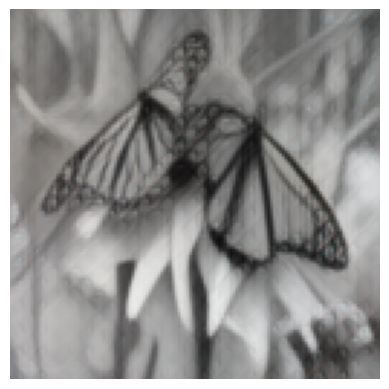

In [13]:
def testNewImage(image, modelA, dimension):
    transform = transforms.Compose([
        transforms.Resize((dimension, dimension)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    image = transform(image)
    image = image.unsqueeze(0)
    X = image
    modelA.eval()
    modelA = modelA.to(device)
    with torch.no_grad():
        quantized_latents, decoderOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss = modelA(X)
    print(f"Dimension of Input Image is : ({dimension},{dimension}, 3), Quantized Latents Shape: {quantized_latents.shape}, Encoding Indices Shape: {encoding_indices.shape}")
    outImage = decoderOut[0]
    outImage = outImage * 0.5 + 0.5
    outImage = outImage.permute(1, 2, 0).cpu().numpy()
    return outImage


image = Image.open("/Users/ishananand/Desktop/Hybrid-Architecture-T2I/Images/testImage2.jpg").convert("RGB")
outImage = testNewImage(image, modelA, dimension=128)
plt.imsave("./images/opt128.png", outImage)
plt.imshow(outImage)
plt.axis("off")
plt.show()

Dimension of Input Image is : (256,256, 3), Quantized Latents Shape: torch.Size([1, 128, 32, 32]), Encoding Indices Shape: torch.Size([1024])


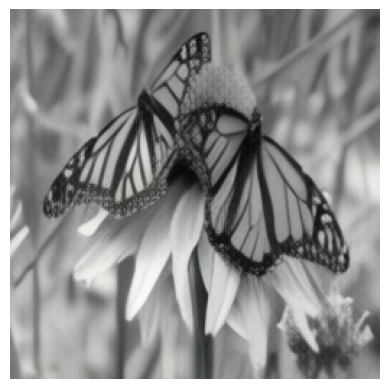

In [14]:
image = Image.open("/Users/ishananand/Desktop/Hybrid-Architecture-T2I/Images/testImage2.jpg").convert("RGB")
outImage = testNewImage(image, modelA, dimension=256)
plt.imsave("./images/opt256.png", outImage)
plt.imshow(outImage)
plt.axis("off")
plt.show()

Dimension of Input Image is : (512,512, 3), Quantized Latents Shape: torch.Size([1, 128, 64, 64]), Encoding Indices Shape: torch.Size([4096])


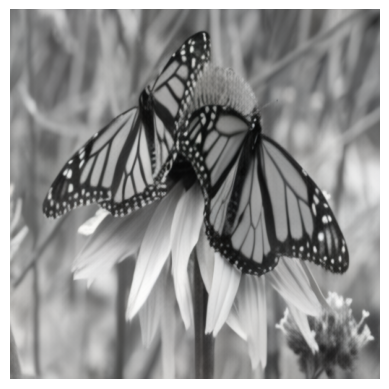

In [15]:
image = Image.open("/Users/ishananand/Desktop/Hybrid-Architecture-T2I/Images/testImage2.jpg").convert("RGB")
outImage = testNewImage(image, modelA, dimension=512)
plt.imsave("./images/opt512.png", outImage)
plt.imshow(outImage)
plt.axis("off")
plt.show()

Dimension of Input Image is : (1024,1024, 3), Quantized Latents Shape: torch.Size([1, 128, 128, 128]), Encoding Indices Shape: torch.Size([16384])


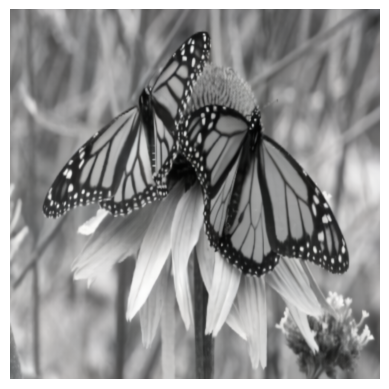

In [16]:
image = Image.open("/Users/ishananand/Desktop/Hybrid-Architecture-T2I/Images/testImage2.jpg").convert("RGB")
outImage = testNewImage(image, modelA, dimension=1024)
plt.imsave("./images/opt1024.png", outImage)
plt.imshow(outImage)
plt.axis("off")
plt.show()